# Implementação e Avaliação do FixMatch com CIFAR-10

### Objetivo
Neste assignment, vocês implementarão o método FixMatch, uma técnica de aprendizado semi-supervisionado que combina aprendizado supervisionado e não supervisionado. O objetivo é aplicar o FixMatch ao dataset CIFAR-10 para treinar uma rede neural e avaliar os resultados obtidos com diferentes proporções de dados rotulados.

### 1. Introdução ao FixMatch
FixMatch é uma técnica que combina pseudo-rotulagem e consistência de dados aumentados. Em resumo, o método:
- **Gera pseudo-rótulos** para dados não rotulados, utilizando uma predição confiável de dados fracamente aumentados.
- **Aplica uma consistência de pseudo-rótulos**, onde a rede é treinada para produzir as mesmas previsões em versões fortemente aumentadas das mesmas imagens.

Para mais informações sobre a arquitetura e a metodologia do FixMatch, vocês podem consultar o [paper original](https://arxiv.org/abs/2001.07685) e/ou ver os slides disponibilizados.

### 2. Estrutura da Implementação

1. **Dataset e Preparação dos Dados**  
   - Use o CIFAR-10 como dataset.
   - Prepare duas versões dos dados:
     - **Dados rotulados:** Utilizem um subconjunto rotulado do CIFAR-10 com diferentes quantidades de rótulos por classe para experimentação.
     - **Dados não rotulados:** O restante do CIFAR-10 deve ser usado como dados não rotulados.

2. **Modelo Base**  
   - Utilize um modelo de CNN simples ou uma arquitetura pré-definida (sugestão: ResNet-18) para a implementação.

3. **Implementação do FixMatch**
   - **Pseudo-rotulagem:** Implemente a geração de rótulos para os dados não rotulados usando predições de confiança de uma versão levemente aumentada da imagem.
   - **Consistência de Augmentation:** Aplique uma versão fortemente aumentada da imagem e treine a rede para manter consistência nos pseudo-rótulos.
   - **Função de Perda**:
     - O FixMatch utiliza uma função de perda híbrida, combinando a perda supervisionada e a não supervisionada:
       - **Perda Supervisionada:** Aplique a entropia cruzada entre os rótulos reais e as predições do modelo para os dados rotulados.
       - **Perda Não Supervisionada (Consistência de Pseudo-rótulos):** Para os dados não rotulados, aplique uma entropia cruzada entre os pseudo-rótulos e as previsões das imagens aumentadas, incluindo apenas as amostras com confiança acima de um limite predefinido (threshold).
       - A função de perda final é a soma ponderada das perdas supervisionada e não supervisionada.

   - **Detalhes Importantes nas Seções 2.3 e 2.4 do paper**;

4. **Treinamento e Otimização**

### 3. Experimentos e Análise

Para avaliar o desempenho do FixMatch, vocês devem realizar experimentos com diferentes quantidades de dados rotulados. Especificamente, testem com:

1. **1 rótulo por classe** (total de 10 rótulos): Este experimento extremo explora o desempenho do FixMatch com uma quantidade mínima de dados rotulados. Observem a eficácia da técnica de pseudo-rotulagem nesse cenário.

2. **4 rótulos por classe** (total de 40 rótulos): Com um conjunto pequeno, analisem o desempenho da rede com algumas amostras rotuladas e o impacto dos pseudo-rótulos.

3. **25 rótulos por classe** (total de 250 rótulos): Esse experimento permitirá uma análise mais profunda da eficácia do FixMatch em cenários com uma quantidade moderada de rótulos.

4. **400 rótulos por classe** (total de 4.000 rótulos): Avaliem o desempenho do modelo com um conjunto mais substancial de dados rotulados, investigando o impacto da quantidade crescente de rótulos.

**Proponha pelo menos mais algum teste, fundamente sua escolha e discuta os resultados.**

Para cada experimento:
   - Treine o modelo e avalie a acurácia nos dados de teste.
   - Documente os resultados e compare a eficácia do FixMatch com a quantidade de dados rotulados disponíveis.
   - Analise o impacto dos pseudo-rótulos na qualidade do modelo, principalmente nos cenários com poucos rótulos (1, 4 e 25 rótulos por classe).

### 4. Apresentação
No final, vocês devem preparar e apresentar:

1. Slides de apresentação ou relatório:
- Explicação da implementação de cada parte do FixMatch. (simples e rápida)
- Resultados e gráficos das avaliações para os quatro cenários de rótulos por classe. (Importante)
- Análise sobre o impacto da quantidade de dados rotulados, a função de perda híbrida, e o efeito dos thresholds e data augmentation. (Importante)

2. Apresentação de 10-15 minutos
- Grave uma apresentação do seu slide/relatório cobrindo todos os pontos pedidos.

*Note que a apresentação e o conteúdo dos slides deve cobrir todos os requisitos solicitados, pois sua avaliação vai depender 90% da apresentação. 



# Imports

In [1]:
import numpy as np
import torchvision

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import decode_image
from ctaugment import CTAugment
from matplotlib import pyplot as plt

from tqdm import tqdm

from math import cos, pi
from collections import defaultdict
from os.path import join
from itertools import cycle
import json

NORMALIZE = False
CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
DEVICE

'cuda'

# Dataset

## Datasets labeled e unlabeled

In [2]:
class LabeledDataset(Dataset):

    def __init__(self, dataset, indexes, device = "cpu"):
        self.dataset = dataset
        self.indexes = indexes
        self.device = device

        self.weak_augmentations = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomAffine(degrees=0, translate=(0.125, 0.125)), # translação em até 12,5% na vertical e horizontal
        ])
        self.normalize_img = v2.Compose([
            v2.ToDtype(torch.float32),
            v2.Normalize([125.307, 122.961, 113.8575], [62.985, 61.965, 66.555])
        ])

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx] 
        image = image.to(torch.float).to(self.device)
        
        image = self.weak_augmentations(image)
        if NORMALIZE:
            image = self.normalize_img(image)
        
        return image, label

    def get_original_image(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx]
        return image.to(torch.float).to(self.device)

In [3]:
class UnlabeledDataset(Dataset):
    def __init__(self, dataset, indexes, ctaugment = False, device = "cpu"):
        self.dataset = dataset
        self.indexes = indexes
        self.device = device
        
        self.weak_augmentations = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomAffine(degrees=0, translate=(0.125, 0.125)), # translação em até 12,5% na vertical e horizontal
        ])

        self.strong_augmentations = v2.Compose([
                CTAugment() if ctaugment else v2.RandAugment(),
                v2.RandomErasing(p=0.0, 
                                ratio=(0.3, 3.3), 
                                scale=(0.25, 0.25), 
                                value=[125.307, 122.961, 113.8575]),

        ])

        self.normalize_img = v2.Normalize([125.307, 122.961, 113.8575], [62.985, 61.965, 66.555])

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx]
        image = image.to(torch.uint8).to(self.device)

        weak_image = self.weak_augmentations(image).to(torch.float)
        strong_image = self.strong_augmentations(image).to(torch.float)
        if NORMALIZE:
            weak_image = self.normalize_img(weak_image)
            strong_image = self.normalize_img(strong_image)

        return weak_image, strong_image

    def get_original_image(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx]
        return image.to(torch.float).to(self.device)

## Split do dataset

In [4]:
def get_split_dataset(dataset, n_classes, n_samples, ctaugment = True, device = "cpu", custom_indexes = None):
    labeled_indexes = []

    if custom_indexes is not None:
        indexes = custom_indexes
    else:
        indexes = torch.randperm(len(dataset))

    total_indexes = n_classes * n_samples
    frequencies = defaultdict(lambda: 0)
    curr = 0

    def __init__(self, dataset, indexes, device = "cpu"):
        self.dataset = dataset
        self.indexes = indexes
        self.device = device

        self.weak_augmentations = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomAffine(degrees=0, translate=(0.125, 0.125)), # translação em até 12,5% na vertical e horizontal
        ])
        self.normalize_img = v2.Compose([
            v2.ToDtype(torch.float32),
            v2.Normalize([125.307, 122.961, 113.8575], [62.985, 61.965, 66.555])
        ])

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx] 
        image = image.to(torch.float).to(self.device)
        
        image = self.weak_augmentations(image)
        if NORMALIZE:
            image = self.normalize_img(image)
        
        return image, label

    def get_original_image(self, idx):
        real_idx = self.indexes[idx]
        image, label = self.dataset[real_idx]
        return image.to(torch.float).to(self.device)

    while len(labeled_indexes) < total_indexes:
        if curr == len(dataset):
            raise RuntimeError("Não foi possível fazer split do dataset")

        label = dataset[indexes[curr]][1]
        if frequencies[label] < n_samples:
            labeled_indexes.append(indexes[curr].item())
            frequencies[label] += 1
        curr += 1
        
    unlabeled_indexes = list(set(range(len(dataset))) - set(labeled_indexes))

    labeled_dataset = LabeledDataset(dataset, labeled_indexes, device)
    unlabeled_dataset = UnlabeledDataset(dataset, unlabeled_indexes, ctaugment, device)
    return labeled_dataset, unlabeled_dataset

In [5]:
#Exemplo:

base_dataset = CIFAR10("data", train = True, download = True, transform = v2.ToImage())
labeled_dataset, unlabeled_dataset = get_split_dataset(base_dataset, 10, 5, True)
len(labeled_dataset), len(unlabeled_dataset), len(labeled_dataset) + len(unlabeled_dataset)

(50, 49950, 50000)

## Teste das augments

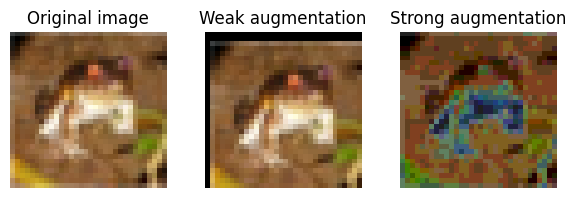

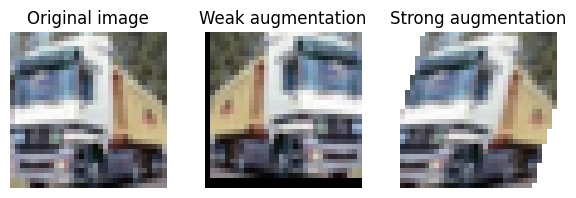

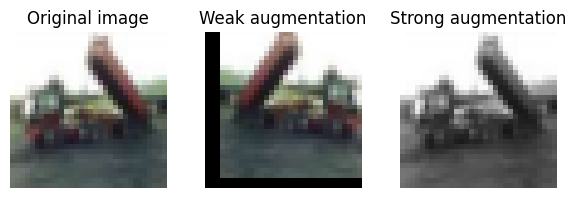

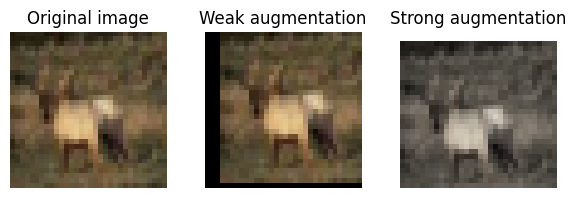

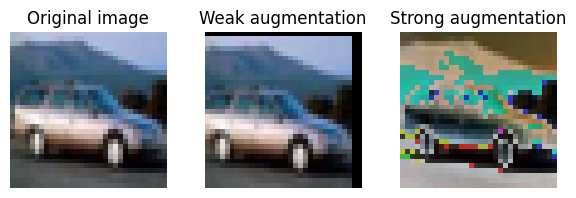

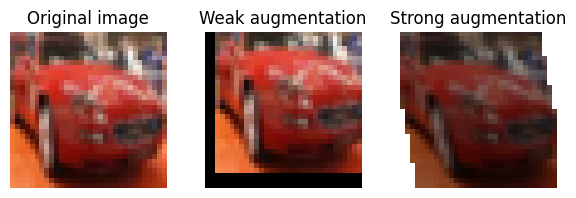

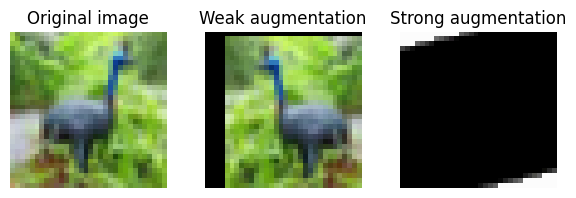

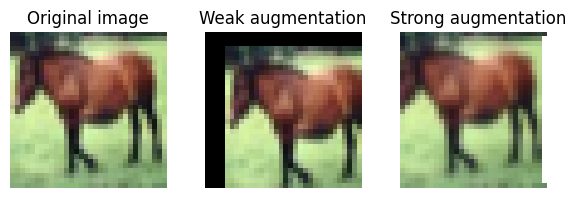

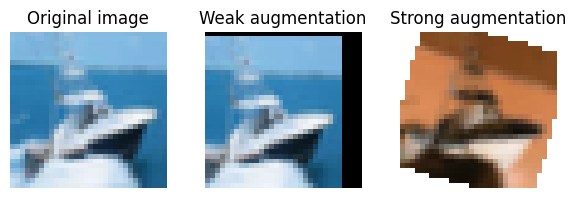

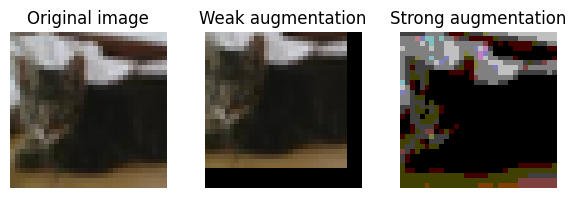

In [6]:
for i in range(10):
    weak_image, strong_image = unlabeled_dataset[i]
    normal_image = unlabeled_dataset.get_original_image(i)

    if NORMALIZE:
        #Desfaz normalização para plot
        std = torch.tensor([62.985, 61.965, 66.555]).view(3, 1, 1) 
        mean = torch.tensor([125.307, 122.961, 113.8575]).view(3, 1, 1)
        weak_image = (weak_image * std) + mean
        strong_image = (strong_image * std) + mean

    fig, axes = plt.subplots(1, 3, figsize=(6, 2))

    axes[0].imshow(normal_image.to(torch.int).permute(1, 2, 0))
    axes[0].set_title("Original image")
    axes[0].axis("off")

    axes[1].imshow(weak_image.to(torch.int).permute(1, 2, 0))
    axes[1].set_title("Weak augmentation")
    axes[1].axis("off")

    axes[2].imshow(strong_image.to(torch.int).permute(1, 2, 0))
    axes[2].set_title("Strong augmentation")
    axes[2].axis("off")

    plt.tight_layout()

    plt.show()

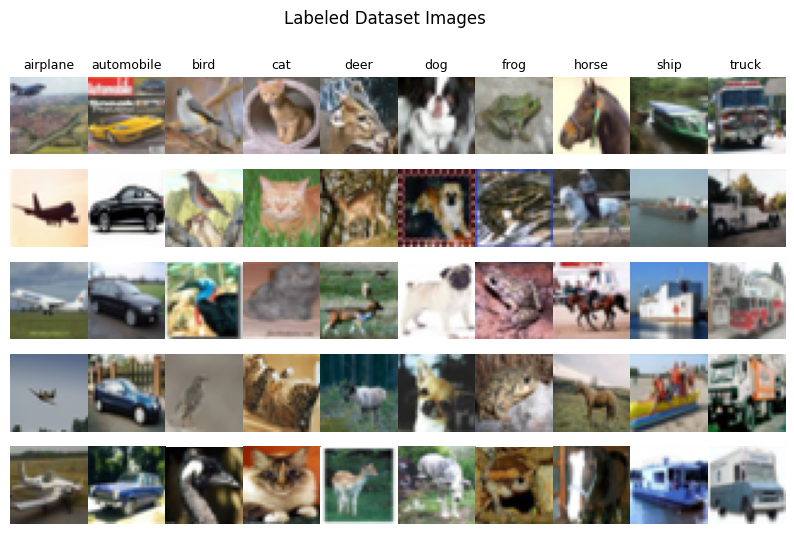

In [7]:
def plot_imgs_labeled(dataset, n_rows=5, title=None):
    n_rows = min(n_rows, int(len(dataset)/10))
    fig, ax = plt.subplots(n_rows, 10, figsize=(10, n_rows+1))
    fig.subplots_adjust(wspace=0, hspace=0)

    row_idx = [0]*10
    for label_idx, class_name in enumerate(CIFAR10_CLASSES):
        if n_rows > 1:
            ax[0, label_idx].set_title(class_name, fontsize=9)
        else:
            ax[label_idx].set_title(class_name, fontsize=9)

    for i, (img, label) in enumerate(dataset):
        if i > 50: break

        if not (row_idx[label]) >= len(ax):
            if n_rows > 1:
                ax[row_idx[label], label].imshow(dataset.get_original_image(i).to(torch.int).permute(1, 2, 0))
                ax[row_idx[label], label].axis("off")
            else:
                ax[label].imshow(dataset.get_original_image(i).to(torch.int).permute(1, 2, 0))
                ax[label].axis("off")
        
        row_idx[label] += 1

    if title:
        fig.suptitle(title)

plot_imgs_labeled(labeled_dataset, title="Labeled Dataset Images")

# Modelo

## Modelo

In [8]:
class ModelResnet18(nn.Module):
    def __init__(self, n_classes, device = "cpu"):
        super().__init__()
        self.device = device
        self.n_classes = n_classes

        self.resnet = resnet18(weights = None)#ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(in_features = 512, out_features = n_classes)
        self = self.to(device)

    def forward(self, x):
        return self.resnet(x)

In [9]:
modelo = ModelResnet18(10)
modelo

ModelResnet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Loss

In [10]:
class FixMatchLoss(nn.Module):
    def __init__(self, threshold, weight):
        super().__init__()
        self.threshold = threshold
        self.weight = weight
        self.cross_entropy = nn.CrossEntropyLoss(reduction = "sum")
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, labeled_predictions, labeled_truth, unlabeled_weak_predictions, unlabeled_strong_predictions):
        l_s = self.cross_entropy(labeled_predictions, labeled_truth)/labeled_truth.shape[0]

        with torch.no_grad():
            unlabeled_weak_predictions = self.softmax(unlabeled_weak_predictions)
            mask = unlabeled_weak_predictions.max(dim = 1)[0] > self.threshold
            if sum(mask) == 0:
                return l_s, 0

        l_u = self.cross_entropy(
            unlabeled_strong_predictions[mask], 
            unlabeled_weak_predictions[mask].argmax(dim = 1)
        )/unlabeled_weak_predictions.shape[0]

        return l_s + self.weight * l_u, sum(mask)

In [11]:
# Exemplo

N = 64
mu = 1.5
C = 10

mock_truth = torch.randint(C, size = (N,))
mock_preds = torch.normal(1.0, 5.0, size = (N, C))
mock_weak_preds = torch.normal(1.0, 5.0, size = (int(N * mu), C))
mock_strong_preds = torch.normal(1.0, 5.0, size = (int(N * mu), C))

loss = FixMatchLoss(0.7, 1)
loss(mock_preds, mock_truth, mock_weak_preds, mock_strong_preds)

(tensor(13.8876), tensor(58))

## Trainer

In [12]:
class Trainer:
    def __init__(self, model, labeled_dataset, unlabeled_dataset, criterion, optimizer, val_dataset = None, device = "cpu"):
        self._model = model.to(device)

        self._labeled_dataset = labeled_dataset
        self._unlabeled_dataset = unlabeled_dataset
        self._val_dataset = val_dataset

        self._criterion = criterion
        self._optimizer = optimizer
        self._device = device

        self.cross_entropy = nn.CrossEntropyLoss()

        print(device)

        self._history = {
            "train_loss": [],
            "val_acc": [],
            "val_loss": [],
            "confidence": []
        }

    @property
    def history(self):
        return self._history
    
    def train_one_epoch(self, epoch, scheduler):
        self._model.train()
        
        running_loss = 0.0
        confidents = 0
        zip_loaders = zip(cycle(self._labeled_dataloader), self._unlabeled_dataloader)
        progress_bar = tqdm(zip_loaders, desc = f"Epoch {epoch + 1} | Training", total = len(self._unlabeled_dataloader))

        for i, (labeled_data, unlabeled_data) in enumerate(progress_bar):
            # labeled_data = next(self._labeled_dataloader)
            # print(i, labeled_data[1].shape, labeled_data[1])

            labeled_images, labeled_labels = labeled_data
            labeled_images = labeled_images.to(self._device)
            labeled_labels = labeled_labels.to(self._device)

            unlabeled_weak, unlabeled_strong = unlabeled_data
            unlabeled_weak = unlabeled_weak.to(self._device)
            unlabeled_strong = unlabeled_strong.to(self._device)

            self._optimizer.zero_grad()

            labeled_predictions = self._model(labeled_images)
            unlabeled_weak_predictions = self._model(unlabeled_weak)
            unlabeled_strong_predictions = self._model(unlabeled_strong)

            loss, confident = self._criterion(
                labeled_predictions,
                labeled_labels,
                unlabeled_weak_predictions,
                unlabeled_strong_predictions,
            )
            loss.backward()
            self._optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss = loss.item(), lr = self._optimizer.param_groups[0]["lr"])
            confidents += int(confident)

        if scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / len(self._unlabeled_dataloader)
        percentage_confiance = 100*confidents/len(self._unlabeled_dataloader.dataset)
        return epoch_loss, percentage_confiance

    def evaluate_accuracy(self, dataloader):
        self._model.eval()
        
        correct = 0
        total = 0
        running_loss = 0

        class_rights = torch.zeros((10,))
        class_totals = torch.zeros((10,))

        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(torch.float).to(self._device)
                labels = labels.to(self._device)
                
                outputs = self._model(images)
                running_loss += self.cross_entropy(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                for class_ in range(10):
                    class_mask = labels == class_
                    class_totals[class_] += class_mask.sum().item()
                    class_rights[class_] += (predicted[class_mask] == labels[class_mask]).sum().item()
                    

                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        epoch_loss = running_loss / len(dataloader)
        return accuracy, epoch_loss, class_rights/class_totals

    def fit(self, epochs, batch_size, mu = 7, num_workers = 0, scheduler = None):
        kwargs = {"shuffle": True, "num_workers": num_workers}
        self._labeled_dataloader = DataLoader(self._labeled_dataset, batch_size=batch_size, **kwargs)
        self._unlabeled_dataloader = DataLoader(self._unlabeled_dataset, batch_size = int(batch_size * mu), **kwargs)
        if self._val_dataset:
            self._val_dataloader = DataLoader(self._val_dataset, batch_size = batch_size, **kwargs)

        for epoch in range(epochs):
            train_loss, confidence = self.train_one_epoch(epoch, scheduler)
            self._history["train_loss"].append(train_loss)
            self._history["confidence"].append(confidence)
            
            if self._val_dataset:
                val_acc, val_loss, class_acc = self.evaluate_accuracy(self._val_dataloader)
                self.history["val_acc"].append(val_acc)
                self.history["val_loss"].append(val_loss)
                print(f"Epoch {epoch + 1}: mean batch loss {train_loss:.3f} | val acc {val_acc}% | val loss {val_loss:.3f} | confidence {confidence:.2f}%")
            else:
                print(f"Epoch {epoch + 1}: mean batch loss {train_loss:.3f} | confiance {confidence:.3f}%")

In [ ]:
n_classes = 10
n_samples = 400
epochs = 2

batch_size = 64
learning_rate = 0.03
threshold = 0.95
lambda_u = 1.0

base_dataset = CIFAR10("data", train=True, download=True, transform=v2.ToImage())
labeled_dataset, unlabeled_dataset = get_split_dataset(base_dataset, n_classes, n_samples, True)

test_dataset = CIFAR10(
    "data", 
    train = False, 
    download = True, 
    transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=False),
        v2.Normalize([125.307, 122.961, 113.8575], [62.985, 61.965, 66.555]) if NORMALIZE else v2.Lambda(lambda x: x),
    ])
)

model = ModelResnet18(n_classes, DEVICE)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(
    model.parameters(),
    lr = learning_rate,
    momentum = 0.9,
    nesterov = True,
    weight_decay = 0.0005
)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda epoch: cos((7*pi*epoch) / (16*epochs))
)
loss_function = FixMatchLoss(threshold, lambda_u)

trainer = Trainer(
    model,
    labeled_dataset,
    unlabeled_dataset,
    loss_function,
    optimizer,
    val_dataset = test_dataset,
    device = DEVICE
)

trainer.fit(epochs, batch_size, num_workers = 3, scheduler = scheduler)

In [ ]:
plt.plot(trainer._history["val_acc"])

In [14]:
torch.save(model.state_dict(), "1_epoch.pth")

In [15]:
with open("1_epoch.json", "w") as f:
    json.dump(trainer._history, f)

# Plots para testes

## Experimento com número de samples por classe

In [16]:
with open("modelo_400_confidence.json", "r") as f:
    historico_400 = json.load(f)

with open("modelo_25_confidence.json", "r") as f:
    historico_25 = json.load(f)

with open("modelo_4_confidence.json", "r") as f:
    historico_4 = json.load(f)

with open("modelo_1_confidence.json", "r") as f:
    historico_1 = json.load(f)

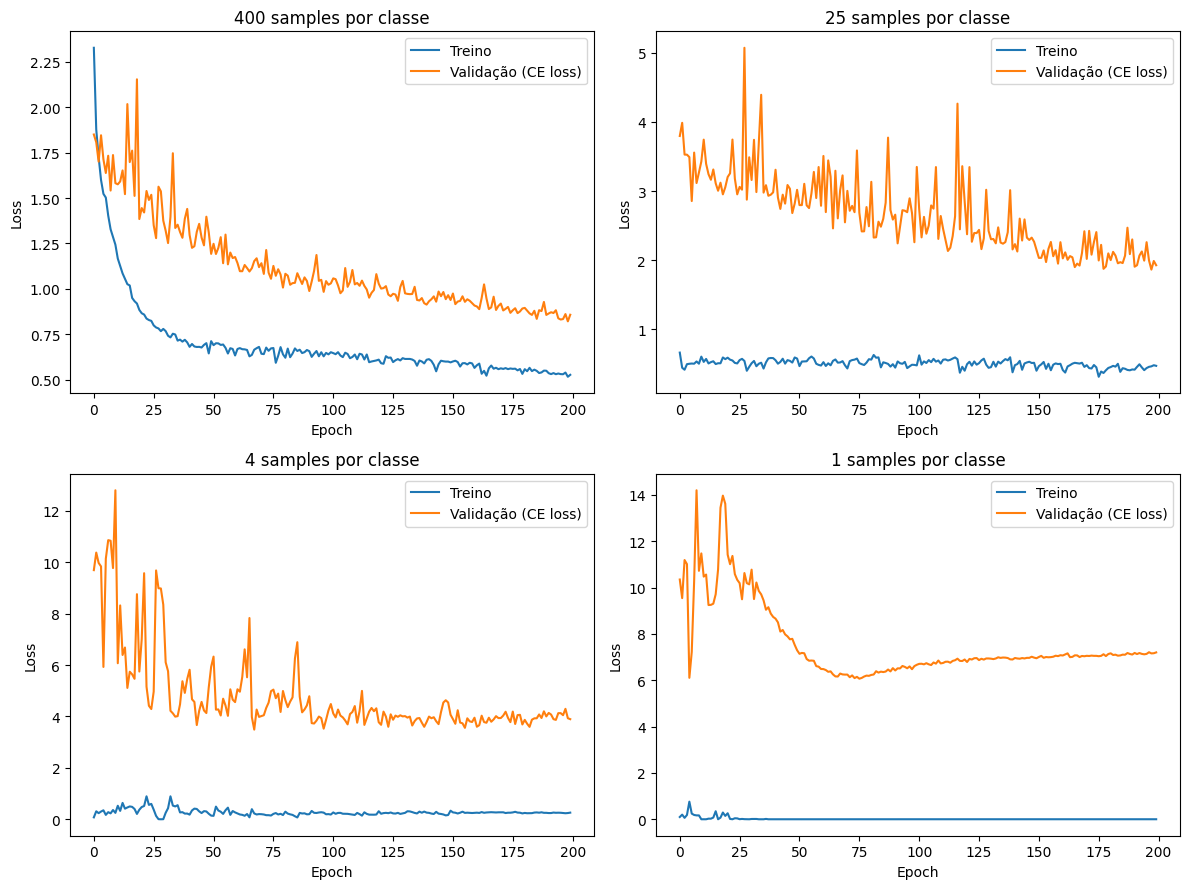

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].plot(historico_400["train_loss"], label = "Treino")
axes[0][0].plot(historico_400["val_loss"], label = "Validação (CE loss)")
axes[0][0].set_title("400 samples por classe")
axes[0][0].legend()
axes[0][0].set_xlabel("Epoch")
axes[0][0].set_ylabel("Loss")
#axes[0][0].set_yscale("log")

axes[0][1].plot(historico_25["train_loss"], label = "Treino")
axes[0][1].plot(historico_25["val_loss"], label = "Validação (CE loss)")
axes[0][1].set_title("25 samples por classe")
axes[0][1].legend()
axes[0][1].set_xlabel("Epoch")
axes[0][1].set_ylabel("Loss")
#axes[0][1].set_yscale("log")

axes[1][0].plot(historico_4["train_loss"], label = "Treino")
axes[1][0].plot(historico_4["val_loss"], label = "Validação (CE loss)")
axes[1][0].set_title("4 samples por classe")
axes[1][0].legend()
axes[1][0].set_xlabel("Epoch")
axes[1][0].set_ylabel("Loss")
#axes[1][0].set_yscale("log")

axes[1][1].plot(historico_1["train_loss"], label = "Treino")
axes[1][1].plot(historico_1["val_loss"], label = "Validação (CE loss)")
axes[1][1].set_title("1 samples por classe")
axes[1][1].legend()
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("Loss")
#axes[1][1].set_yscale("log")

plt.tight_layout()

plt.show()

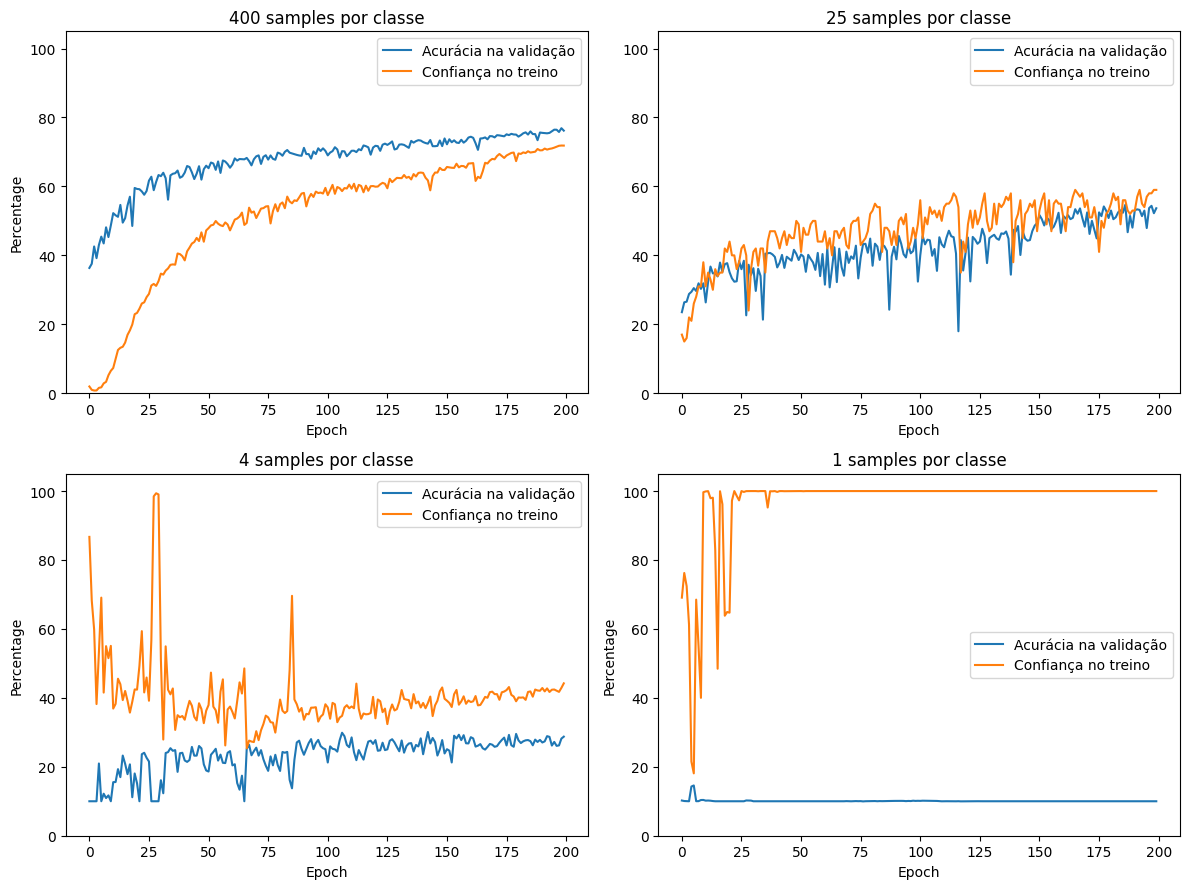

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].plot(historico_400["val_acc"], label = "Acurácia na validação")
axes[0][0].plot(historico_400["confidence"], label = "Confiança no treino")
axes[0][0].set_title("400 samples por classe")
axes[0][0].legend()
axes[0][0].set_xlabel("Epoch")
axes[0][0].set_ylabel("Percentage")
axes[0][0].set_ybound(0, 105)

axes[0][1].plot(historico_25["val_acc"], label = "Acurácia na validação")
axes[0][1].plot(historico_25["confidence"], label = "Confiança no treino")
axes[0][1].set_title("25 samples por classe")
axes[0][1].legend()
axes[0][1].set_xlabel("Epoch")
axes[0][0].set_ylabel("Percentage")
axes[0][1].set_ybound(0, 105)

axes[1][0].plot(historico_4["val_acc"], label = "Acurácia na validação")
axes[1][0].plot(historico_4["confidence"], label = "Confiança no treino")
axes[1][0].set_title("4 samples por classe")
axes[1][0].legend()
axes[1][0].set_xlabel("Epoch")
axes[1][0].set_ylabel("Percentage")
axes[1][0].set_ybound(0, 105)

axes[1][1].plot(historico_1["val_acc"], label = "Acurácia na validação")
axes[1][1].plot(historico_1["confidence"], label = "Confiança no treino")
axes[1][1].set_title("1 samples por classe")
axes[1][1].legend()
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 105)

plt.tight_layout()

plt.show()

## Experimentos com cutout e augmentation

In [19]:
with open("modelo_400_confidence_ctaugment_no_cutout.json", "r") as f:
    historico_400_ct_no_cutout = json.load(f)

with open("modelo_400_confidence_ctaugment_certo.json", "r") as f:
    historico_400_ct_cutout = json.load(f)

with open("modelo_prototipo_400_RandAug_confidence_no_cutout.json", "r") as f:
    historico_400_rand_no_cutout = json.load(f)

with open("modelo_prototipo_400_RandAug.json", "r") as f:
    historico_400_rand_cutout = json.load(f)

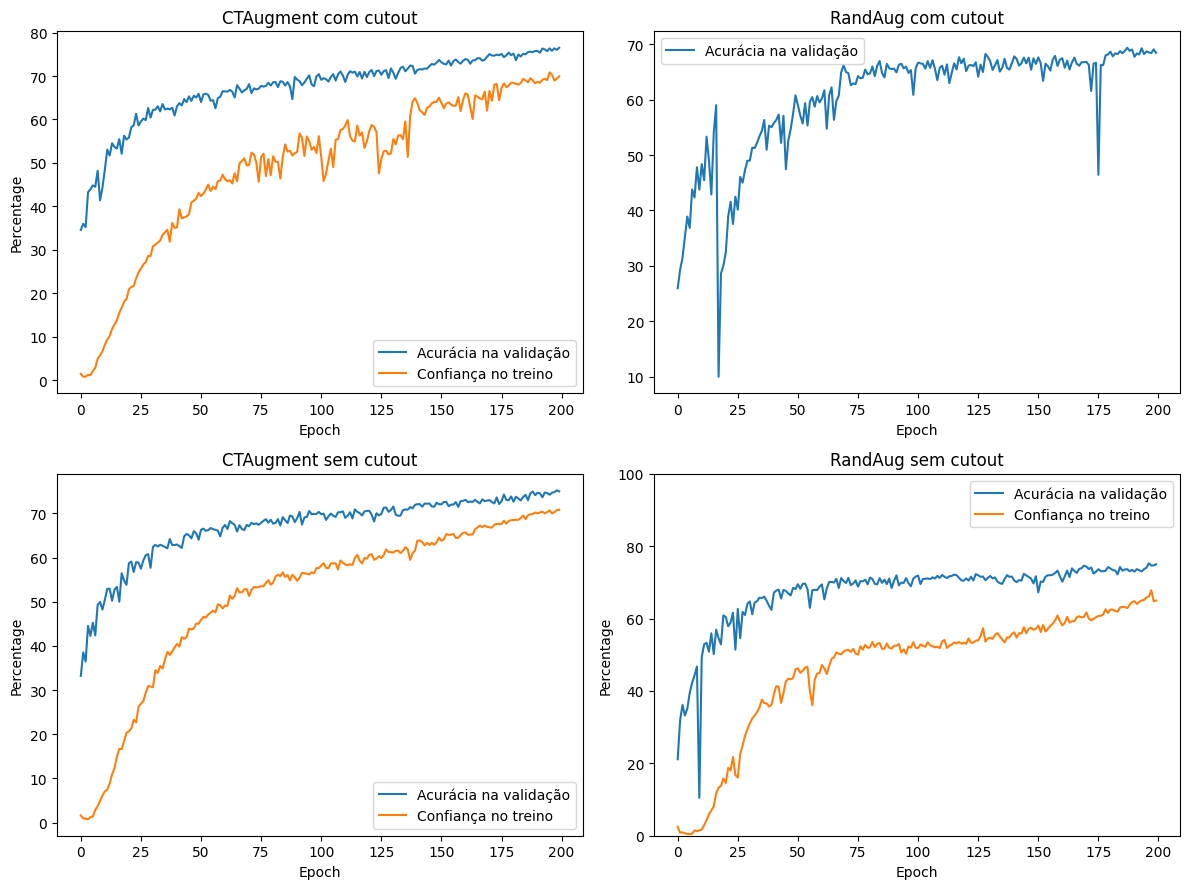

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].plot(historico_400_ct_cutout["val_acc"], label = "Acurácia na validação")
axes[0][0].plot(historico_400_ct_cutout["confidence"], label = "Confiança no treino")
axes[0][0].set_title("CTAugment com cutout")
axes[0][0].legend()
axes[0][0].set_xlabel("Epoch")
axes[0][0].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 100)

axes[0][1].plot(historico_400_rand_cutout["val_acc"], label = "Acurácia na validação")
#axes[0][1].plot(historico_400_rand_cutout["confidence"], label = "Confiança no treino")
axes[0][1].set_title("RandAug com cutout")
axes[0][1].legend()
axes[0][1].set_xlabel("Epoch")
axes[0][0].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 100)

axes[1][0].plot(historico_400_ct_no_cutout["val_acc"], label = "Acurácia na validação")
axes[1][0].plot(historico_400_ct_no_cutout["confidence"], label = "Confiança no treino")
axes[1][0].set_title("CTAugment sem cutout")
axes[1][0].legend()
axes[1][0].set_xlabel("Epoch")
axes[1][0].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 100)

axes[1][1].plot(historico_400_rand_no_cutout["val_acc"], label = "Acurácia na validação")
axes[1][1].plot(historico_400_rand_no_cutout["confidence"], label = "Confiança no treino")
axes[1][1].set_title("RandAug sem cutout")
axes[1][1].legend()
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 100)

plt.tight_layout()

plt.show()

In [21]:
print(historico_400_ct_no_cutout["val_acc"][199])
print(historico_400_ct_cutout["val_acc"][199])
print(historico_400_rand_no_cutout["val_acc"][199])
print(historico_400_rand_cutout["val_acc"][199])


74.95
76.49
75.01
68.45


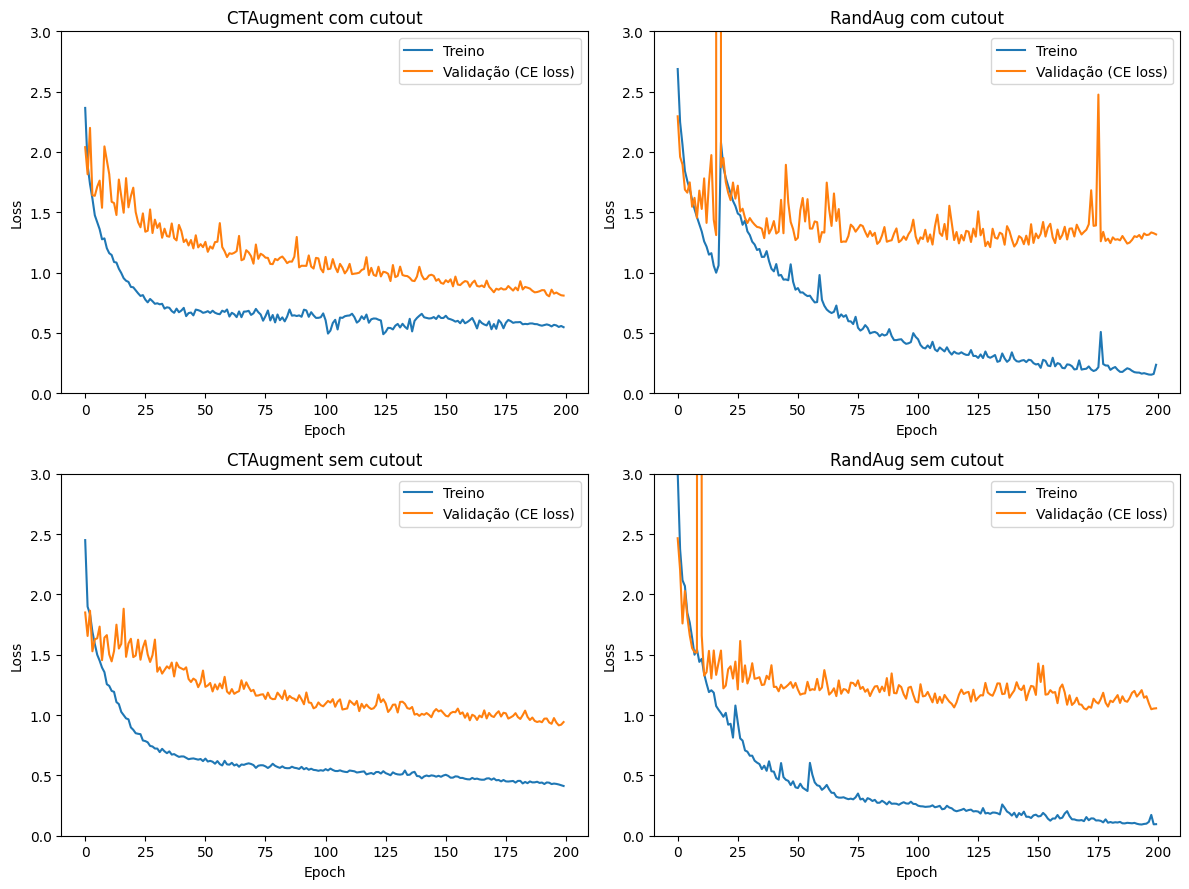

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].plot(historico_400_ct_cutout["train_loss"], label = "Treino")
axes[0][0].plot(historico_400_ct_cutout["val_loss"], label = "Validação (CE loss)")
axes[0][0].set_title("CTAugment com cutout")
axes[0][0].legend()
axes[0][0].set_xlabel("Epoch")
axes[0][0].set_ylabel("Loss")
#axes[0][0].set_yscale("log")
axes[0][0].set_ybound(0, 3)

axes[0][1].plot(historico_400_rand_cutout["train_loss"], label = "Treino")
axes[0][1].plot(historico_400_rand_cutout["val_loss"], label = "Validação (CE loss)")
axes[0][1].set_title("RandAug com cutout")
axes[0][1].legend()
axes[0][1].set_xlabel("Epoch")
axes[0][1].set_ylabel("Loss")
#axes[0][1].set_yscale("log")
axes[0][1].set_ybound(0, 3)

axes[1][0].plot(historico_400_ct_no_cutout["train_loss"], label = "Treino")
axes[1][0].plot(historico_400_ct_no_cutout["val_loss"], label = "Validação (CE loss)")
axes[1][0].set_title("CTAugment sem cutout")
axes[1][0].legend()
axes[1][0].set_xlabel("Epoch")
axes[1][0].set_ylabel("Loss")
#axes[1][0].set_yscale("log")
axes[1][0].set_ybound(0, 3)

axes[1][1].plot(historico_400_rand_no_cutout["train_loss"], label = "Treino")
axes[1][1].plot(historico_400_rand_no_cutout["val_loss"], label = "Validação (CE loss)")
axes[1][1].set_title("RandAug sem cutout")
axes[1][1].legend()
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("Loss")
#axes[1][1].set_yscale("log")
axes[1][1].set_ybound(0, 3)

plt.tight_layout()

plt.show()

## Testes com imagens não representativas

### Treino da CNN e identificação de imagens não representativas

In [ ]:
transform = transforms.ToTensor()

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
eval_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(DEVICE)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

criterion_per_sample = nn.CrossEntropyLoss(reduction='none')

all_losses = []
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in eval_loader:
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        outputs = model(inputs)

        losses = criterion_per_sample(outputs, labels)
        
        all_losses.append(losses.cpu())
        all_predictions.append(outputs.argmax(dim=1).cpu())
        all_labels.append(labels.cpu())

all_losses = torch.cat(all_losses)

Epoch [1/15], Loss: 1.5414


In [ ]:
sorted_indices_hard_first = torch.argsort(all_losses, descending=True)
sorted_indices_easy_first = torch.argsort(all_losses, descending=False)

In [ ]:
base_dataset = CIFAR10("data", train = True, download = True, transform = v2.ToImage())

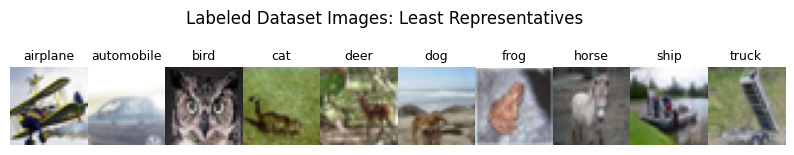

In [ ]:
labeled_dataset, unlabeled_dataset = get_split_dataset(base_dataset, 10, 1, True, custom_indexes=sorted_indices_hard_first)
plot_imgs_labeled(labeled_dataset, title="Labeled Dataset Images: Least Representatives")

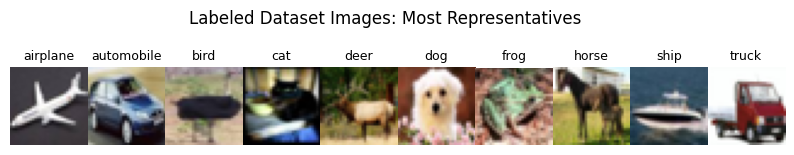

In [ ]:
labeled_dataset, unlabeled_dataset = get_split_dataset(base_dataset, 10, 1, True, custom_indexes=sorted_indices_easy_first)
plot_imgs_labeled(labeled_dataset, title="Labeled Dataset Images: Most Representatives")

In [ ]:
epochs = 200

batch_size = 64
learning_rate = 0.03
threshold = 0.95
lambda_u = 1.0

model = ModelResnet18(n_classes, DEVICE)

optimizer = optim.SGD(
    model.parameters(),
    lr = learning_rate,
    momentum = 0.9,
    nesterov = True,
    weight_decay = 0.0005
)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda epoch: cos((7*pi*epoch) / (16*epochs))
)
loss_function = FixMatchLoss(threshold, lambda_u)

trainer = Trainer(
    model,
    labeled_dataset,
    unlabeled_dataset,
    loss_function,
    optimizer,
    val_dataset = test_dataset,
    device = DEVICE
)

trainer.fit(epochs, batch_size, num_workers = 3, scheduler = scheduler)

### Resultados

In [ ]:
with open("modelo_400_confidence_ctaugment_certo.json", "r") as f:
    historico_400_ct_cutout = json.load(f)

with open("modelo_experimento.json", "r") as f:
    historico_experimento = json.load(f)

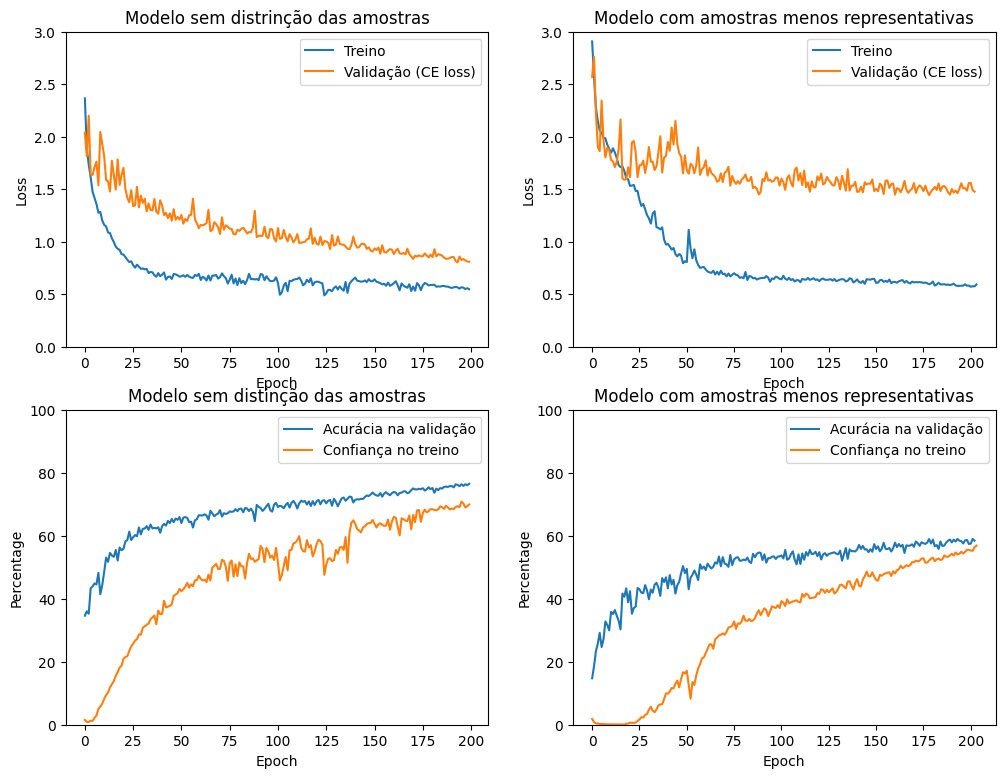

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].plot(historico_400_ct_cutout["train_loss"], label = "Treino")
axes[0][0].plot(historico_400_ct_cutout["val_loss"], label = "Validação (CE loss)")
axes[0][0].set_title("Modelo sem distrinção das amostras")
axes[0][0].legend()
axes[0][0].set_xlabel("Epoch")
axes[0][0].set_ylabel("Loss")
#axes[0][0].set_yscale("log")
axes[0][0].set_ybound(0, 3)

axes[0][1].plot(historico_experimento["train_loss"], label = "Treino")
axes[0][1].plot(historico_experimento["val_loss"], label = "Validação (CE loss)")
axes[0][1].set_title("Modelo com amostras menos representativas")
axes[0][1].legend()
axes[0][1].set_xlabel("Epoch")
axes[0][1].set_ylabel("Loss")
#axes[0][1].set_yscale("log")
axes[0][1].set_ybound(0, 3)

axes[1][0].plot(historico_400_ct_cutout["val_acc"], label = "Acurácia na validação")
axes[1][0].plot(historico_400_ct_cutout["confidence"], label = "Confiança no treino")
axes[1][0].set_title("Modelo sem distinção das amostras")
axes[1][0].legend()
axes[1][0].set_xlabel("Epoch")
axes[1][0].set_ylabel("Percentage")
axes[1][0].set_ybound(0, 100)

axes[1][1].plot(historico_experimento["val_acc"], label = "Acurácia na validação")
axes[1][1].plot(historico_experimento["confidence"], label = "Confiança no treino")
axes[1][1].set_title("Modelo com amostras menos representativas")
axes[1][1].legend()
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("Percentage")
axes[1][1].set_ybound(0, 100)
